<a href="https://colab.research.google.com/github/im-govinth/LSTM_Text_Generator/blob/main/text_generation_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import sys

In [28]:
df=pd.read_csv('train.csv')

In [29]:
df.head()

,title,text,subject,date
0,Greens say no support for Macron's EZ budget i...,BERLIN (Reuters) - None of the German parties ...,worldnews,"October 25, 2017"
1,Trump faces uphill battle to overcome court's ...,(Reuters) - U.S. President Donald Trump faces ...,politicsNews,"February 6, 2017"
2,Ukraine president denies hampering anti-corrup...,VILNIUS/KIEV (Reuters) - Ukrainian President P...,worldnews,"December 8, 2017"
3,U.S. defense chief: White House shakeup will n...,BRUSSELS (Reuters) - U.S. Defense Secretary Ji...,politicsNews,"February 14, 2017"
4,Irish government set to fall weeks before Brex...,DUBLIN (Reuters) - Ireland s minority governme...,worldnews,"November 24, 2017"


In [30]:
text = " ".join(df['text'].dropna().astype(str)).lower()
print(f'Total characters in text: {len(text)}')

Total characters in text: 35695884


In [31]:
vocab = sorted(set(text))
print(f'Vocabulary size: {len(vocab)}')

char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Vocabulary size: 104


In [32]:
seq_length = 100

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    return chunk[:-1], chunk[1:]

dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [33]:
num_sequences = len(text_as_int) // (seq_length + 1)
total_batches = max(1, num_sequences // BATCH_SIZE)
val_batch_count = max(1, int(0.1 * total_batches))

In [34]:
val_ds = dataset.take(val_batch_count)
train_ds = dataset.skip(val_batch_count)

In [35]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [36]:
vocab_size = len(vocab)
embedding_dim = 64
rnn_units = 256

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(vocab_size)
])


loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam', loss=loss_obj)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 64)       │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 256)      │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, None, 256)      │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 104)      │        26,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887,400 (3.39 MB)

 Trainable params: 887,400 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
ckpt_path = "lstm_textgen_best.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path, monitor='val_loss', save_best_only=True, verbose=1
)

early_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

In [38]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, early_cb]
)

Epoch 1/20
4968/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1098
Epoch 1: val_loss improved from inf to 1.38470, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 138s 25ms/step - loss: 2.1096 - val_loss: 1.3847
Epoch 2/20
4970/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4360
Epoch 2: val_loss improved from 1.38470 to 1.27156, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.4360 - val_loss: 1.2716
Epoch 3/20
4968/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3395
Epoch 3: val_loss improved from 1.27156 to 1.22538, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.3394 - val_loss: 1.2254
Epoch 4/20
4968/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2953
Epoch 4: val_loss improved from 1.22538 to 1.19858, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2953 - val_loss: 1.1986
Epoch 5/20
4968/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2691
Epoch 5: val_loss improved from 1.19858 to 1.18027, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2691 - val_loss: 1.1803
Epoch 6/20
4968/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2511
Epoch 6: val_loss improved from 1.18027 to 1.16834, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2511 - val_loss: 1.1683
Epoch 7/20
4969/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2379
Epoch 7: val_loss improved from 1.16834 to 1.15858, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2379 - val_loss: 1.1586
Epoch 8/20
4969/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2278
Epoch 8: val_loss improved from 1.15858 to 1.15105, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2278 - val_loss: 1.1510
Epoch 9/20
4969/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2199
Epoch 9: val_loss improved from 1.15105 to 1.14460, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2199 - val_loss: 1.1446
Epoch 10/20
4968/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2136
Epoch 10: val_loss improved from 1.14460 to 1.13956, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2136 - val_loss: 1.1396
Epoch 11/20
4969/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2082
Epoch 11: val_loss improved from 1.13956 to 1.13511, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 111s 22ms/step - loss: 1.2082 - val_loss: 1.1351
Epoch 12/20
4970/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2039
Epoch 12: val_loss improved from 1.13511 to 1.13234, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2039 - val_loss: 1.1323
Epoch 13/20
4968/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2000
Epoch 13: val_loss improved from 1.13234 to 1.12932, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.2000 - val_loss: 1.1293
Epoch 14/20
4970/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1981
Epoch 14: val_loss improved from 1.12932 to 1.12770, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.1981 - val_loss: 1.1277
Epoch 15/20
4968/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1945
Epoch 15: val_loss improved from 1.12770 to 1.12438, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.1945 - val_loss: 1.1244
Epoch 16/20
4969/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1920
Epoch 16: val_loss improved from 1.12438 to 1.12223, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.1920 - val_loss: 1.1222
Epoch 17/20
4970/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1896
Epoch 17: val_loss improved from 1.12223 to 1.12047, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.1896 - val_loss: 1.1205
Epoch 18/20
4970/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1878
Epoch 18: val_loss improved from 1.12047 to 1.11918, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 111s 22ms/step - loss: 1.1878 - val_loss: 1.1192
Epoch 19/20
4969/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1852
Epoch 19: val_loss improved from 1.11918 to 1.11676, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.1852 - val_loss: 1.1168
Epoch 20/20
4970/4970 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1830
Epoch 20: val_loss improved from 1.11676 to 1.11550, saving model to lstm_textgen_best.h5


4970/4970 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - loss: 1.1830 - val_loss: 1.1155
Restoring model weights from the end of the best epoch: 20.


In [39]:
from tensorflow.keras.models import load_model
best = load_model('/content/lstm_textgen_best.h5', compile=False)

In [40]:
def generate_text_from_model(model, start_string, num_generate=300, temperature=1.0):
    input_eval = [char2idx.get(s, 0) for s in start_string.lower()]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    for _ in range(num_generate):
        preds = model(input_eval)                # (1, seq_len, vocab)
        last_logits = preds[:, -1, :] / max(1e-8, temperature)
        sampled_id = tf.random.categorical(last_logits, num_samples=1)[0,0].numpy()
        text_generated.append(idx2char[sampled_id])
        input_eval = tf.concat([input_eval, tf.expand_dims([sampled_id], 0)], axis=1)
        if input_eval.shape[1] > seq_length:
            input_eval = input_eval[:, -seq_length:]
    return start_string + ''.join(text_generated)

In [41]:
seeds = ["The ", "Once upon a time, ", "In a world "]
temps = [0.2, 0.5, 1.0]
for seed in seeds:
    for t in temps:
        print("---- SEED:", repr(seed), "TEMP:", t, "----")
        print(generate_text_from_model(best, seed, num_generate=400, temperature=t))
        print("\n\n")

---- SEED: 'The ' TEMP: 0.2 ----
The country s conservatives and the constitutional committee on thursday and includes the country s control of the presidential campaign and the court and the committee said on thursday that the country s conservative committee said on thursday that the country s weapons and anti-community was starting to be denied and a surprise to the senate intelligence committee on thursday to be a lot of the coun



---- SEED: 'The ' TEMP: 0.5 ----
The united states and conservative president donald trump and the occupied trade export stance to the first term is stopped and has referred to the president in 2013 to look over the position of a saudi arabia strategy to continue a senate decision to decide the campaign to delay the justices of the majority of a head of the trump administration’s primary on monday.  washington (reuters) - president d



---- SEED: 'The ' TEMP: 1.0 ----
The northern iranian stapities’ to the half china to astrophen and will reply to the 

In [42]:
outfile = '/content/generated_samples.txt'
with open(outfile, 'w', encoding='utf-8') as f:
    for seed in seeds:
        for t in temps:
            txt = generate_text_from_model(best, seed, num_generate=400, temperature=t)
            f.write(f"SEED: {seed}  TEMP: {t}\n")
            f.write(txt + "\n\n" + ("="*80) + "\n\n")
print("Saved samples to", outfile)

Saved samples to /content/generated_samples.txt


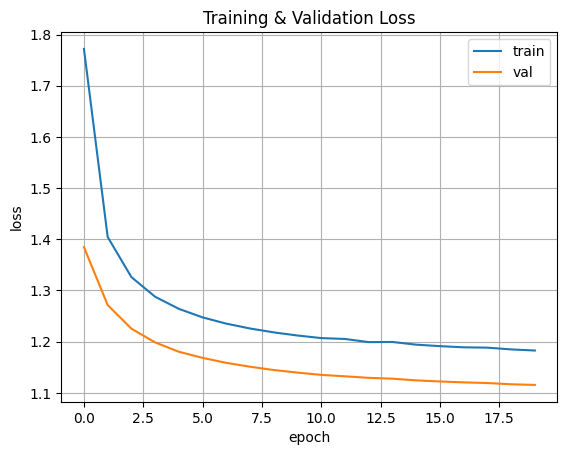

In [43]:
import matplotlib.pyplot as plt

# assumes `history` object from model.fit is available
plt.plot(history.history['loss'], label='train')
plt.plot(history.history.get('val_loss', []), label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(True)
plt.title('Training & Validation Loss')
plt.show()

In [44]:
best.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
val_loss = best.evaluate(val_ds)   # returns scalar loss
import math
val_perplexity = math.exp(val_loss)
print(f"Validation loss: {val_loss:.4f}  —  Perplexity: {val_perplexity:.2f}")

552/552 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.1177
Validation loss: 1.1155  —  Perplexity: 3.05


In [45]:
# Save in native Keras format
best.save('/content/lstm_textgen_best.keras')   # recommended format

# Save char2idx mapping
import json
with open('/content/char2idx.json', 'w', encoding='utf-8') as f:
    json.dump(char2idx, f, ensure_ascii=False)

# Save idx2char as list
with open('/content/idx2char.json', 'w', encoding='utf-8') as f:
    json.dump(idx2char.tolist(), f, ensure_ascii=False)